# DALL-E - Generating Images from Text

* [DALLE-pytorch](https://github.com/lucidrains/DALLE-pytorch)

In [1]:
!pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 144.6MB 91kB/s 
     |████████████████████████████████| 61kB 4.3MB/s 
ERROR: earthengine-api 0.1.255 has requirement google-api-python-client>=1.12.1, but you'll have google-api-python-client 1.8.0 which is incompatible.


In [2]:
# PyTorch/XLA GPU Setup (only if GPU runtime)
import os
if os.environ.get('COLAB_GPU', '0') == '1':
  os.environ['GPU_NUM_DEVICES'] = '1'
  os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda/'

In [3]:
# --- Remember to change the runtime to use GPU for better performance
!nvidia-smi
!pip install -Uqq dalle-pytorch

Sun Mar 21 07:24:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%load_ext autoreload
%autoreload 2

In [8]:
import logging
import torch
import numpy as np
import math
import itertools
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%config InlineBackend.figure_format = 'retina'
from PIL import Image
from tqdm.autonotebook import tqdm, trange
import torch
from dalle_pytorch import OpenAIDiscreteVAE, DALLE

logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)
vae = OpenAIDiscreteVAE()

In [50]:
def generate_images(captions):
    captions = [[captions]]
    all_words = list(sorted(frozenset(sum(captions, []))))
    word_tokens = dict(zip(all_words, range(1, len(all_words) + 1)))
    caption_tokens = [[word_tokens[w] for w in c] for c in captions]
    logging.info(f"{caption_tokens}")

    longest_caption = max(len(c) for c in captions)
    captions_array = np.zeros((len(caption_tokens), longest_caption), dtype=np.int64)
    for i in range(len(caption_tokens)):
        captions_array[i, : len(caption_tokens[i])] = caption_tokens[i]

    captions_array = torch.from_numpy(captions_array).cuda()
    captions_mask = captions_array != 0


    dalle = DALLE(
      dim = 1024,
      vae = vae,                  # automatically infer (1) image sequence length and (2) number of image tokens
      num_text_tokens = 10000,    # vocab size for text
      #text_seq_len = 256,         # text sequence length
      text_seq_len=longest_caption,  
      depth = 1,                  # should aim to be 64
      heads = 16,                 # attention heads
      dim_head = 64,              # attention head dimension
      attn_dropout = 0.1,         # attention dropout
      ff_dropout = 0.1            # feedforward dropout
    ).cuda()

    #dalle = DALLE(
    #    dim=p1024,
    #    vae=vae, 
    #    num_text_tokens=len(word_tokens) + 1,  
    #    text_seq_len=longest_caption,  
    #    depth=12,  
    #    heads=16, 
    #    dim_head=64,  
    #    attn_dropout=0.1,  
    #    ff_dropout=0.1,  
    #).cuda()

    generated_images = []
    with torch.no_grad():
        for i in trange(0, len(captions), 128):
            generated = dalle.generate_images(captions_array[i:i + 128, ...], mask=captions_mask[i:i + 128, ...], temperature=0.00001)
            generated_images.append(generated)
          
    return torch.cat(generated_images, axis=0).cpu().numpy()

    

## Generate Images

In [51]:
generated_images = generate_images("a baby daikon radish in a tutu walking a dog")

2021-03-21 08:22:27 INFO     [[1]]


(1, 3, 256, 256)


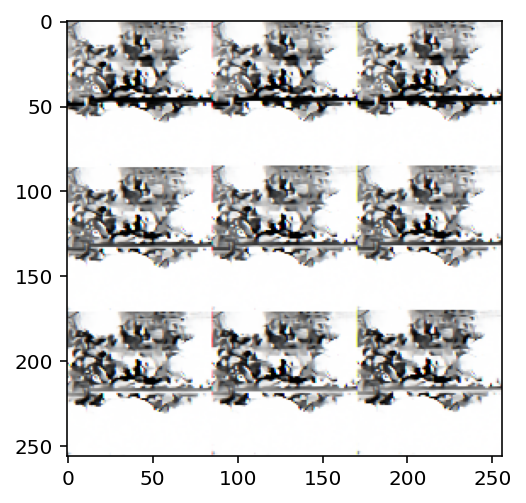

In [52]:
print(generated_images.shape)
images = generated_images[0,...].reshape(256,256,3)
plt.imshow(images)

# decoded_pics = generated_images[0, ...].transpose(0, 2, 3, 1).reshape(320, 256, 3).transpose(1, 0, 2)
# both = np.concatenate(decoded_pics, axis=0)
# plt.imshow(both)